### Introduction: 
The idea of this notebook is to display a proof of concept appliation of using Max-Cut recursively to determine quarantine groups among a target network/population, which minimizes the interaction between the groups. We first show the procedure on a toy example of a 30 regular graphs, and then take steps to make our models more realistic and closer to real world cases, incorporating first shared classes and then housing situations

In [73]:
from collections import defaultdict
import numpy as np
from itertools import combinations
from dwave.system.samplers import DWaveSampler
from dwave.system import LeapHybridSampler
from dwave.system.composites import EmbeddingComposite
from matplotlib import pyplot as plt
import networkx as nx
import networkx.generators.community as community
from networkx.generators.random_graphs import connected_watts_strogatz_graph as small_world 
from networkx.generators import gnp_random_graph as random_graph
import ndlib
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.utils import multi_runs
from bokeh.palettes import Category20_9 as cols
import future.utils
import random
import warnings
from random import randint
warnings.simplefilter('ignore')
%matplotlib inline

### Max-Cut on D-Wave machines functions

In [68]:
def maxcut_qubo(G):
    """
    Generate a QUBO instance Q representing Max-Cut on G
    """
    Q = defaultdict(int)
    for u, v in G.edges:
        Q[(u,u)]+= -1
        Q[(v,v)]+= -1
        Q[(u,v)]+= 2
    return Q

def solve(Q, chainstrength=8, numruns=100):
    """
    Solve a QUBO Q on a D-Wave machine 
    """
    #sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True})) MOVED TO HYBRID SAMPLER
    sampler = LeapHybridSampler()
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())
    return response.first

def brute_best(G):
    """
    Brute force calculate the highest possible Max-Cut cost function value on G
    """
    sub_lists = []
    for i in range(0, len(G.nodes())+1):
        temp = [list(x) for x in combinations(G.nodes(), i)]
        sub_lists.extend(temp)   
    # Calculate the cut_size for all possible cuts
    cut_size = []
    for sub_list in sub_lists:
        cut_size.append(nx.algorithms.cuts.cut_size(G,sub_list))
    return max(cut_size)

def binary_split(G, limit = 4, pos=None, infected_nodes=[], graph=False, print_progress=False, weighted=False):
    """ 
    Recursively call Max-Cut on graph G, splitting into groups until the size of each group reaches limit.
    infected_nodes, graph, pos, and print_progress allow for visualizing process
    weighted allows for weighted Max-Cut
    history allows for viewing the history of cuts made
    """

    if G.number_of_nodes() <= limit or G.number_of_edges() == 0: #recursion base case and if no edges D-Wave will error
        return [G]
    else: # split into two groups       
        if weighted == False:
            Q = maxcut_qubo(G)
        else:
            Q = weighted_maxcut_qubo(G)
        sol = solve(Q)
        
    labels = sol.sample
    for node in G.nodes: # D-Wave doesn't assign labels to isolated vertices randomly assign these
        if node not in labels:
            labels[node] = random.choice([0, 1])
    
    # assign all nodes labeled 0 to 'left' and all else to 'right.' Color left red, right blue, and infected green
    colors = ['g' if i in infected_nodes else ('r' if labels[i] == 0 else 'b') for i in G.nodes]
    left = [i for i in G.nodes if labels[i] == 0] 
    right = [i for i in G.nodes if labels[i] == 1]
    
    # graphing and reporting progress
    if graph:
        fig = plt.figure(constrained_layout=False)
        gs = fig.add_gridspec(nrows=2, ncols=3)
        gs.update(wspace=0, hspace=0)
        ax1 = fig.add_subplot(gs[:,:2])   
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax2 = fig.add_subplot(gs[0,2])  
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax3 = fig.add_subplot(gs[1,2]) 
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])    
    left_G = G.subgraph(left)
    right_G = G.subgraph(right)
    left_colors = ['g' if i in infected_nodes else 'r'  for i in left_G.nodes]
    right_colors = ['g' if i in infected_nodes else 'b' for i in right_G.nodes]
    if print_progress == True:
        print("Divided {} people into {} & {}".format(G.number_of_nodes(), left_G.number_of_nodes(), right_G.number_of_nodes()))    
    if graph:       
        if pos == None:
            pos = nx.spring_layout(G)
        nx.draw_networkx(G, node_size=300, alpha=.8, ax=ax1, pos=pos, node_color=colors)
        nx.draw_networkx(left_G, node_size=300, alpha=.8, ax=ax2, pos=pos, node_color=left_colors)
        nx.draw_networkx(right_G, node_size=300, alpha=.8, ax=ax3, pos=pos, node_color=right_colors)
    
    #recursively call Max-Cut on left and right groups
    groups = []
    groups.extend(binary_split(left_G,  limit=limit, pos=pos, infected_nodes=infected_nodes, 
                              graph=graph, print_progress=print_progress, weighted=weighted))    
    groups.extend(binary_split(right_G, limit=limit, pos=pos, infected_nodes=infected_nodes, 
                              graph=graph, print_progress=print_progress, weighted=weighted))     
    
    return groups

### Plotting functions

In [55]:
def plot_colorized_groups(G, groups, infected):
    """
    Visualize binary split by assigning a random color to each quarantine group in G
    """
    def n_random_colors(n):
        colors = []
        for i in range(n):
            colors.append('#%06X' % randint(0, 0xFFFFFF))
        return colors

    node_colors = [None for i in G.nodes]
    palette = n_random_colors(len(groups))
    for graph, color in zip(groups, palette):
        for node in graph.nodes:
            node_colors[node] = color
    for node in infected:
        node_colors[node] = 'red'

    pos = nx.spring_layout(G)
    fig = plt.figure(figsize=(10,10))
    default_axes = fig.add_subplot(frameon=True)

    nx.draw_networkx(G, node_size=50, with_labels=False, width = .1, alpha=1, node_color=node_colors)
    default_axes.set_title("")
    plt.show()

def plot(viz, ax, title):
    """
    Plot the spread of disease over time 
    viz: Data returned by virus simulations
    ax: axis to plot on
    group_status: title of plot
    """
    pres = viz.iteration_series(90)
    mx = 0
    i = 0
    for k, l in future.utils.iteritems(pres):
        mx = len(l[0])
        if viz.normalized:
            ax.plot(range(0, mx), l[1]/viz.nnodes, lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0,  mx), l[0]/viz.nnodes, l[2]/viz.nnodes, alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        else:
            ax.plot(range(0, mx), l[1], lw=2, label=viz.srev[k], alpha=0.5, color=cols[i])
            ax.fill_between(range(0, mx), l[0], l[2], alpha=0.2, # had to change alpha to a float
                             color=cols[i])
        i += 1
    ax.grid(axis="y")
    ax.set_title(title, fontsize = 14)
    ax.set_xlabel("Days", fontsize=16)
    ax.set_ylabel("Fraction of Population", fontsize=16)
    ax.legend(loc="best", fontsize=16)
    ax.set_xlim((0, mx))

def plot_comparison(G, infected, r_infect=0.001, r_recover=0.01, iterations = 100, group_sizes = [4,16], weighted = False):    
    """
    Plot side by side comparisons of disease spread in the quarantined and un-quarantined cases for groups of size
    given by group_sizes and determined by binary_split
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    original_viz = DiffusionTrend(original_model, original_trends)
    for l in group_sizes:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        groups = binary_split(G, infected_nodes = infected, limit = l, weighted = weighted)
        model, trends = sim_virus_group(G, groups, original_model, r_infect = r_infect, r_recover = r_recover,
                                        original_infected_nodes = infected, iteration = iterations)
        viz = DiffusionTrend(model, trends)
        plot(viz, ax[0], "Quarantined Into {} Groups Using Quantum Computer".format(len(groups)))
        plot(original_viz, ax[1], 'No Quarantine')

### Epidemic Modelling functions

In [13]:
def sim_virus(G, r_infect=0.001, r_recover=0.01, infected_nodes = [], iteration=500):
    """
    Simulates virus spread on entire graph G with initial infected nodes and disease properties
    iteration: number of steps of virus spread
    returns: model, trends: dictionary indexed by number of susceptible (0), infected (1) and removed (2) nodes
    iterations: dictionary indexed by iteration, containing the state of every node at that iteration
    https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html
    """
    model = ep.SIRModel(G)
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', r_infect) # infection rate
    cfg.add_model_parameter('gamma', r_recover) # recovery rate
    cfg.add_model_initial_configuration("Infected", infected_nodes)
    model.set_initial_status(cfg)
    iterations = model.iteration_bunch(iteration, node_status=False)
    trends = model.build_trends(iterations)     
    return model, trends, iterations 


def sim_virus_group(G, groups, original_model, r_infect=0.001, r_recover=0.01, original_infected_nodes = [], iteration=500):
    """
    Simulate virus spread in each quarantined group in groups seperately, 
    Aggregate virus spread in each group to whole population and return stats
    """
    net_trends = {'trends': {'node_count': {0:[0]*iteration, 1:[0]*iteration, 2:[0]*iteration}}}
    for g in groups:
        model, trends, iterations = sim_virus(g, r_infect, r_recover, [n for n in original_infected_nodes if n in g.nodes], iteration)
        for idx,i in enumerate(iterations):
            i_count = i['node_count']
            for jk, jv in i_count.items():
                net_trends['trends']['node_count'][jk][idx] += jv
    for i in range(iteration):
        ctr = net_trends['trends']['node_count'][0][i]+net_trends['trends']['node_count'][1][i]+net_trends['trends']['node_count'][2][i]
        assert ctr == len(G.nodes), (ctr,i)
    return original_model, [net_trends]


# Test on 30 node complete graph toy example

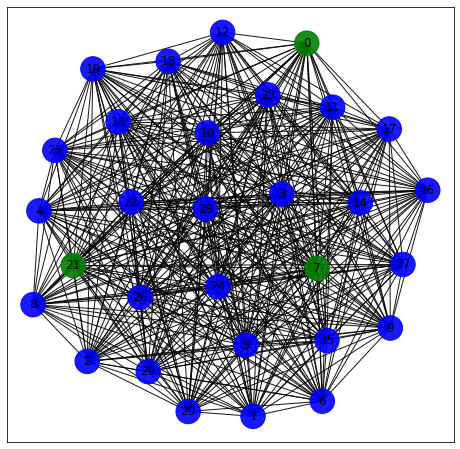

In [15]:
n = 30
init_infect = 0.1
G = nx.generators.classic.complete_graph(n)
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(8,8))
default_axes = fig.add_subplot(frameon=True)
infected = np.random.choice(range(n), int(n*init_infect), replace=False)
colors = ['g' if i in infected else 'b' for i in G.nodes]
nx.draw_networkx(G, node_size=600, alpha=.9, node_color=colors)
plt.show()

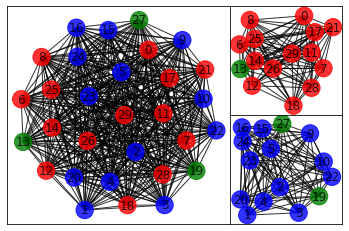

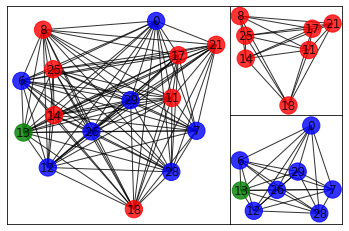

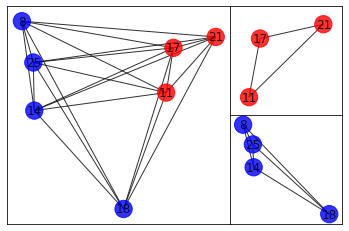

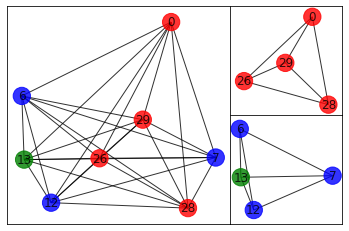

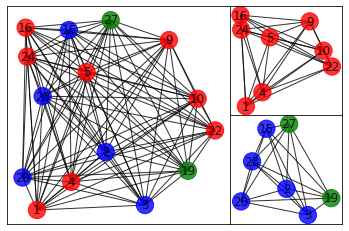

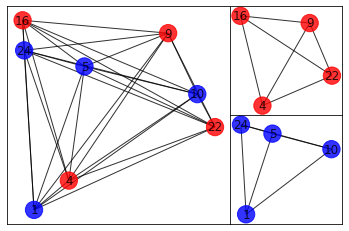

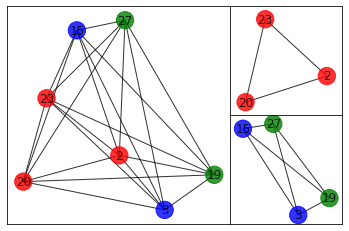

In [111]:
groups = binary_split(G, infected_nodes = infected, limit = 4, graph = True)

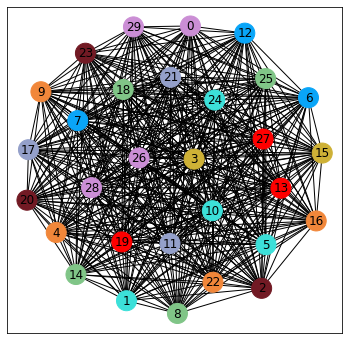

infected people are red


In [112]:
plot_colorized_groups(G, groups, infected)
print('infected people are red')

100%|██████████████████████████████████████████████████████████████████████████████| 600/600 [00:00<00:00, 2759.65it/s]


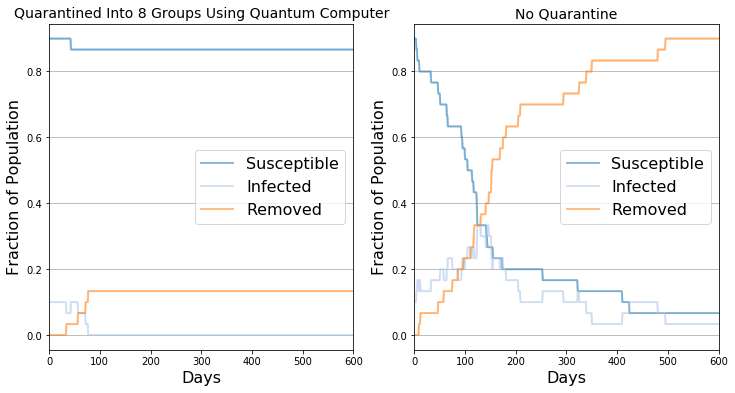

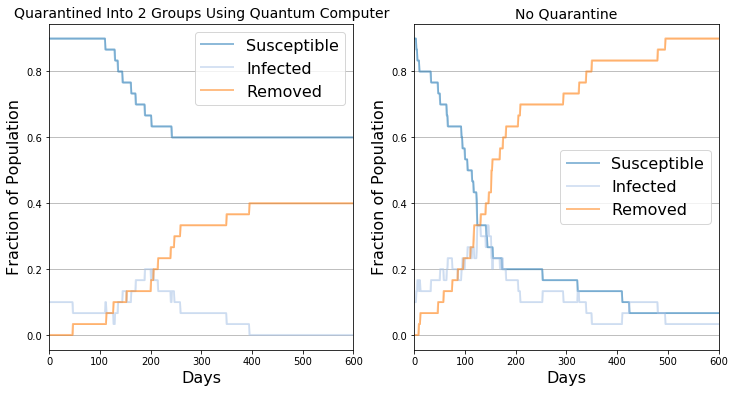

In [18]:
# Lets try plotting the comparison
plot_comparison(G, infected, iterations = 600)

A brief note on interpreting these graphs: The removed value at equilibrium (flat lines) tells you the total fraction of infected people at the end of the virus spread process. The highest point on the infected curve tells you the "peak" of the spread. In heath care we may want to reduce total infections or "flatten the curve" which refer to each of these, respectively.

Observations:

We would need to actually look more into the trends, but I'm guessing that whats happening here is that in the grouped into >=4 case, we have around 7 or 8 groups, and in some of them the growth blows up too fast, infecting the whole group, while in others, the growth dies off. Since the groups are entirely isolated and small, this all happens within the first 50 iterations, and then every one either recovers or remains not sick. This is why the rates become constant, I dont think that it's a bug. Ideally, if everyone was individually quarantined the rates would be constant the whole time, because at point of quarantine either you have it or you dont, so it wouldnt change, which is what we expect/want actually.

# Questions

###### 1) Can you find more reasonable graph? 

https://docs.google.com/document/d/1sIhKVY2pnwngybutyI44d0tuzlTnAOyHB3FnjxcpAr8/edit 
Notes for this question can be found here
In summary, we are looking for a sparse watts-strogatz (small-world) network to model college campuses

As a next step we should try to figure out how to make one node possibly part of more than one community, since a person can be part of school, family, friend group, sport team etc...

Also, we have a notebook testing properties of various networkx graph generators in this folder as:

"Testing Networkx Graph Generators.ipynb"

###### 2) What are the correct r_infect and r_recover rates to use for a given graph?

See "Testing SIR epidemic Spread model on Small-World Graphs.ipynb." 

Gives r_infect = .6/avg_degree(G) and r_recover = .1

###### 3) How much better is a D-Wave max-cut grouping than a random grouping?

We will test this below

###### 4) What about inter-dorm/dining interactions?

We can assign students to dorms based on which group they are assigned to. We will look into this below

###### 5) Can you make the cut dependent on the infected people rather than blindly separating?

Possible solution: weight every edge connecting an infected person to a non-infected and non-recovered person by (constant/#nodes) so that the edge is likely to be cut NOTE: This assumes everybody is tested with accuracy and is knowledgeble of their evolving condition in real time, this is not the case in the US but seems to be in some countries like South Korea, Iceland. It may be the case that it would make sense to either remove an infected vertex from the algo to begin with, or use D-Wave built in fixed variables. ALSO, infected nodes could be isolated a priori, so it may not be as fruitful to think about this case.

# Answering Q3: Testing Quantum vs Random Quarantine on a Small-World Network

In [38]:
def avg_degree(G):
    return 2 * G.number_of_edges() / G.number_of_nodes()

In [39]:
cornell_approx_n = 3800
# parameters explained in "Testing D-Wave Hybrid Solver Capabilities on Small World Graphs"
cornell_approx = small_world(cornell_approx_n, 152, .15) 
cornell_approx_init_infect = 0.1
cornell_approx_infected = np.random.choice(range(cornell_approx_n), int(cornell_approx_n*cornell_approx_init_infect), 
                                           replace=False)
cornell_approx_avg_degree = avg_degree(cornell_approx)

In [116]:
# Just testing if splitting works before calling plot_comparison
groups = binary_split(cornell_approx, infected_nodes = cornell_approx_infected, limit = 500, print_progress = True)

Divided 3800 people into 1900 & 1900
Divided 1900 people into 958 & 942
Divided 958 people into 478 & 480
Divided 942 people into 470 & 472
Divided 1900 people into 951 & 949
Divided 951 people into 478 & 473
Divided 949 people into 470 & 479


100%|██████████████████████████████████████████████| 100/100 [00:03<00:00, 32.31it/s]


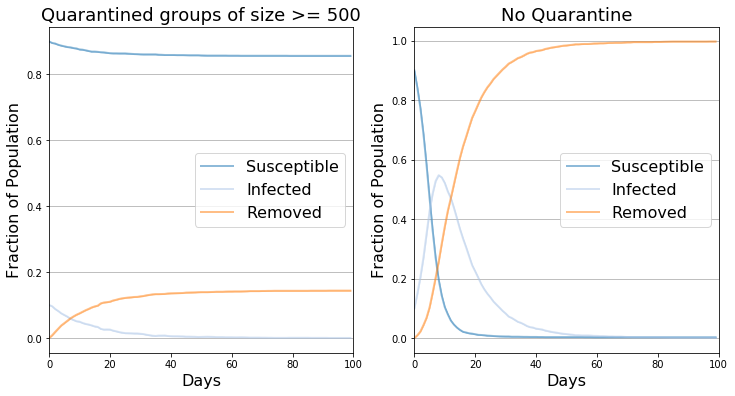

In [117]:
plot_comparison(cornell_approx, cornell_approx_infected, r_infect = .6/cornell_approx_avg_degree, 
                r_recover = .1, group_sizes = [500], iterations = 100)

This looks promising, but let's compare it to a case of randomly breaking the population into 8 quarantine groups as a control

In [34]:
def random_grouping(G, num_groups):
    """
    Return a list of num_groups subgraphs of G of similar size and chosen randomly
    """
    group_nodes = [[] for _ in range(num_groups)]
    for person in range(G.number_of_nodes()):
        random.choice(group_nodes).append(person)
    return [nx.Graph.subgraph(G, nodes) for nodes in group_nodes]

In [35]:
def plot_random_unquarantined_comparison(G, infected, num_groups_list=[8], r_infect=0.001, r_recover=0.01, iterations = 100, weighted = False):    
    """
    Plot side by side comparisons of disease spread in the quarantined and un-quarantined cases for groups of size
    given by group_sizes and determined by randomized group assignment
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    original_viz = DiffusionTrend(original_model, original_trends)
    for num_groups in num_groups_list:
        
        group_graphs = random_grouping(G, num_groups)
        model, trends = sim_virus_group(G, group_graphs, original_model, r_infect = r_infect, r_recover = r_recover,
                                        original_infected_nodes = infected, iteration = iterations)
        viz = DiffusionTrend(model, trends)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        plot(viz, ax[0], "Quarantined Into {} Groups Using Randomized Algorithm".format(num_groups))
        plot(original_viz, ax[1], 'No Quarantine')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 29.18it/s]


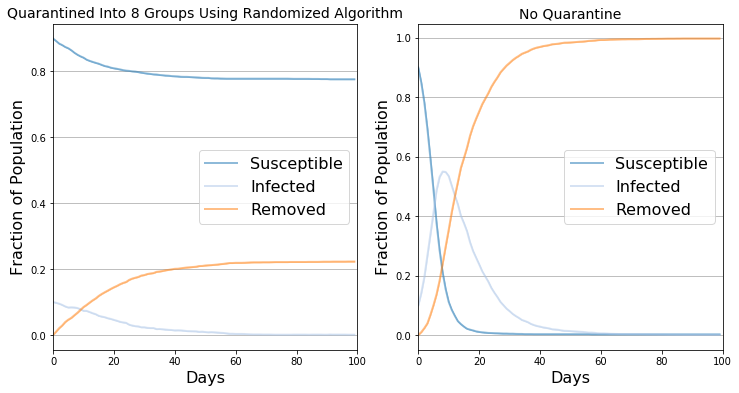

In [40]:
plot_random_unquarantined_comparison(cornell_approx, cornell_approx_infected, num_groups_list=[8], r_infect = .6/cornell_approx_avg_degree, 
                r_recover = .1, iterations = 100)

This result shows that random quarantining also works really well for small world networks, suggesting that we need to try to more closely compare the efficacy of quantum vs random quarantining

In [120]:
def plot_random_quantum_comparison(G, infected, group_sizes=[250, 500, 1000], r_infect=0.001, r_recover=0.01, iterations = 100, weighted = False):    
    """
    Plots side by side the disease spread in the quantum quarantine and random quarantine case for the same number of quarantine groups
    """
    original_model, original_trends, _ = sim_virus(G, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    for group_size in group_sizes:

        
        quantum_groups = binary_split(G, infected_nodes = infected, limit = group_size, weighted = weighted)
        quantum_model, quantum_trends = sim_virus_group(G, quantum_groups, original_model, r_infect = r_infect, r_recover = r_recover,
                                                        original_infected_nodes = infected, iteration = iterations)
        quantum_viz = DiffusionTrend(quantum_model, quantum_trends)

        num_groups = len(quantum_groups)      
        random_group_graphs = random_grouping(G, num_groups)       
        random_model, random_trends = sim_virus_group(G, random_group_graphs, original_model, r_infect = r_infect, r_recover = r_recover,
                                                      original_infected_nodes = infected, iteration = iterations)
        random_viz = DiffusionTrend(random_model, random_trends)
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
        plot(random_viz, ax[0], "Quarantined Into {} Groups Using Randomized ".format(num_groups))
        plot(quantum_viz, ax[1], "Quarantined Into {} Groups Using Quantum Computer".format(num_groups))

100%|██████████████████████████████████████████████| 100/100 [00:07<00:00, 13.34it/s]


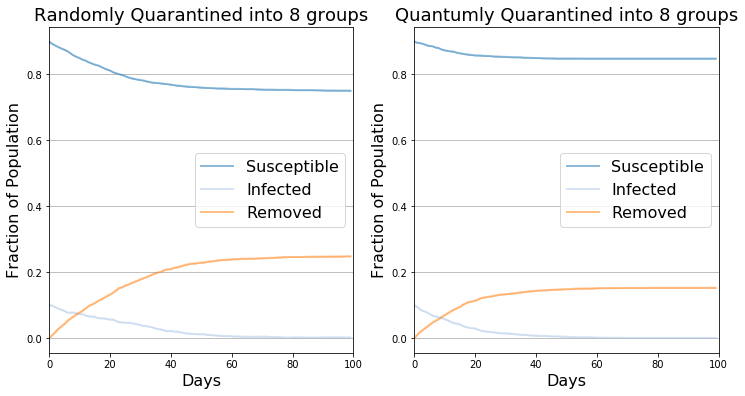

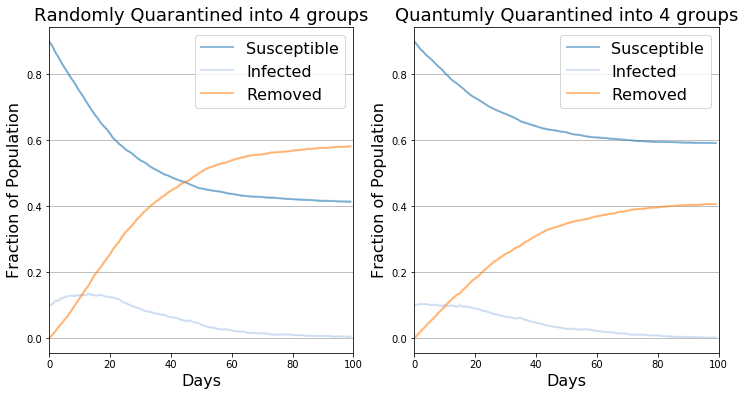

In [121]:
plot_random_quantum_comparison(cornell_approx, cornell_approx_infected, group_sizes = [500, 1000], 
                               r_infect = .6/cornell_approx_avg_degree, r_recover = .1, iterations = 100)

Lets try to do the same thing except with 20% initial infection rate

100%|██████████████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


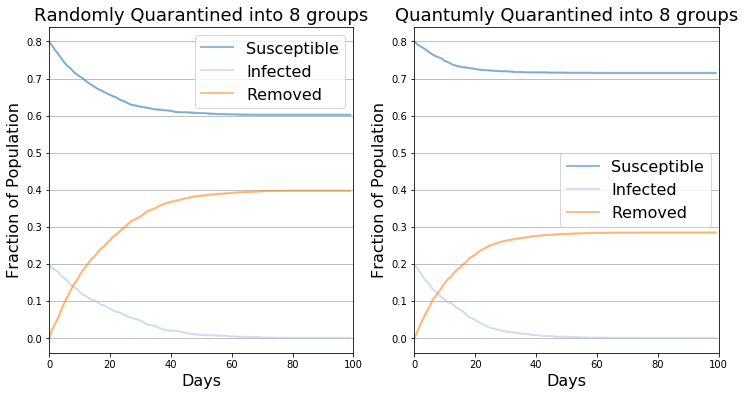

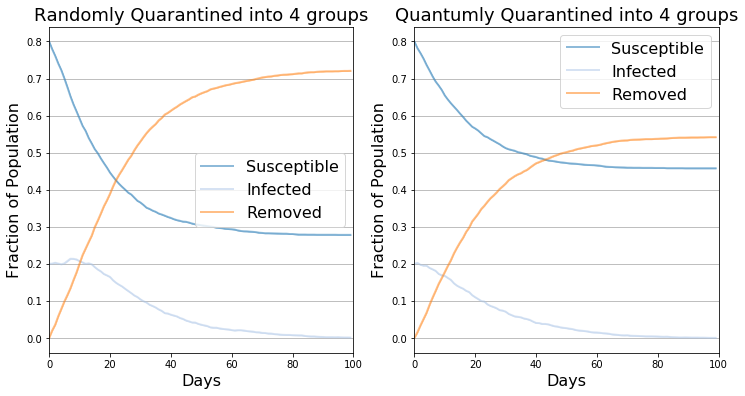

In [122]:
cornell_approx_20p_infect = 0.2
cornell_approx_20p_infected = np.random.choice(range(cornell_approx_n), int(cornell_approx_n*cornell_approx_20p_infect), 
                                           replace=False)
plot_random_quantum_comparison(cornell_approx, cornell_approx_20p_infected, group_sizes = [500, 1000], 
                               r_infect = .6/cornell_approx_avg_degree, r_recover = .1, iterations = 100)

What if 5% are infected to begin

100%|██████████████████████████████████████████████| 100/100 [00:06<00:00, 14.48it/s]


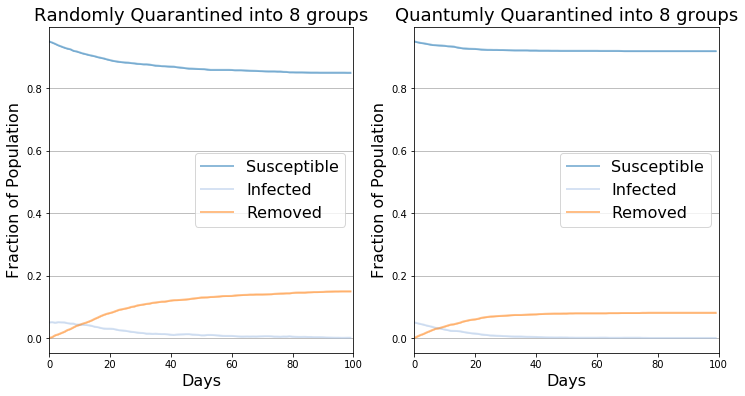

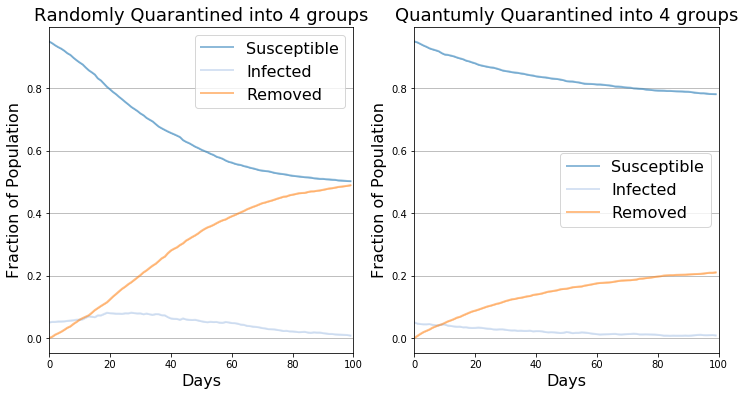

In [123]:
cornell_approx_5p_infect = 0.05
cornell_approx_5p_infected = np.random.choice(range(cornell_approx_n), int(cornell_approx_n*cornell_approx_5p_infect), 
                                           replace=False)
plot_random_quantum_comparison(cornell_approx, cornell_approx_5p_infected, group_sizes = [500, 1000], 
                               r_infect = .6/cornell_approx_avg_degree, r_recover = .1, iterations = 100)

#### Conclusion:
Quantum quarantining into 4 groups saves over half of the students compared to random!

# Answering Q4: Adding dorm edges and random edges

Our idea is that for a small enough college with the right resources, a Max-Cut assignment of students might inform housing placements for a given semester. If students are grouped into dorms, we can try to add in edges to represent dorm interactions. We are going to assume all students live in college housing, this is almost true for some colleges https://docs.google.com/document/d/1sIhKVY2pnwngybutyI44d0tuzlTnAOyHB3FnjxcpAr8/edit. We thus need to decide some basic things for our college campus model: The number of dorm buildings, the size of each building, and the number of floors per building. We can then make each dorm floor a complete graph, add random edges between members of different floors with a relatively high probability, and add edges between any two random students with lower probability

Harvey Mudd has approximately: 100% students on campus, 800 students, 8 dorms. Each dorm has average of two floors. We can first try to model the spread with random dorm assigments obtained by repeatedly selecting 100 students from the course network, placing 50 on each floor of a dorm, adding in dorm edges as described above, and running a virus simulation. We can then run our algorithm on the course network, and use this to assign students to dorms, and run the virus simulation on this network. We can then compare the two.

### Toy model of college campus for visualization purposes

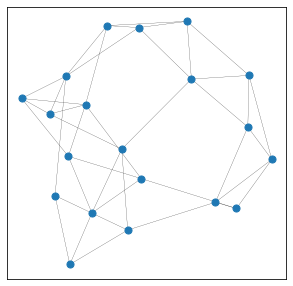

In [154]:
# for visualization lets look at a campus names toyU
toyU_n = 20
toyU = small_world(toyU_n, 4, .15) 
plt.figure(figsize = (5,5))
nx.draw_networkx(toyU, node_size=50, with_labels=False, width = .2)

In [144]:
toyU_10p_infected = np.random.choice(range(toyU_n), int(toyU_n * .1), 
                                           replace=False)
toyU_random_group_graphs = random_grouping(toyU, 4)
toyU_quantum_group_graphs = binary_split(toyU, limit = 7, print_progress=True)

The quantum algorithm ran 4 layers of maxcut, we can use the third to determine dorm and fourth to determine floor. This is easily done by noting the binary_split function outputs subgraphs in order of the leaves of a binary tree from left to right

In [75]:
def relabel(a, b):
    """
    Relabels nodes in graph a to the nodes in graph b, unordered
    """
    assert(a.number_of_nodes() == b.number_of_nodes())
    a_nodes = list(a.nodes)
    b_nodes = list(b.nodes)
    a_to_b_mapping = {}
    for a_node, b_node in zip(a_nodes, b_nodes):
        a_to_b_mapping[a_node] = b_node
    return nx.relabel_nodes(a, a_to_b_mapping)

In [129]:
def construct_campus_graph(G, floors, floors_per_dorm, floor_edge_prob, dorm_edge_prob, random_edge_prob):
    """
    Takes subgraphs from each floor, and return a full graph representing all the physical interactions on a campus.
    We will use this so far in the case that len(floors), floors_per_dorm are powers of 2
    G: original graph of students with edges representing shared courses
    floors: a list of subgraphs (usually given by binary_split)
    floors_per_dorm: int
    floor_edge, dorm_edge, and random_edge_prob, probability of edge between floormates, dormmates, and non-dormmates
    """
    floor_graphs_with_floor_edges = []
    for floor in floors:
        # add new random edges
        floor_new_edges =  random_graph(floor.number_of_nodes(), floor_edge_prob)
        # relabel the nodes to match labels of students on the given floor
        floor_new_edges_labeled = relabel(floor_new_edges, floor)
        # combine the two graphs
        floor_graphs_with_floor_edges.append(nx.compose(floor, floor_new_edges_labeled))

    
    dorm_graphs_with_dorm_edges = []
    for dorm in range(int(len(floors)/floors_per_dorm)):
        # list all floors in the dorm
        floors_in_dorm = floor_graphs_with_floor_edges[floors_per_dorm*dorm : floors_per_dorm*(dorm+1)]
        # construct dorm graph from individual floor graphs
        dorm_graph = nx.empty_graph() 
        for floor in floors_in_dorm:
            dorm_graph = nx.compose(dorm_graph, floor)
        # add in dorm edges
        dorm_new_edges = random_graph(dorm_graph.number_of_nodes(), dorm_edge_prob)
        dorm_new_edges_labeled = relabel(dorm_new_edges, dorm_graph)
        dorm_graphs_with_dorm_edges.append(nx.compose(dorm_graph, dorm_new_edges_labeled))

    # add in random edges for all students regardless of dorm or floor sharing
    cross_campus_graph = random_graph(G.number_of_nodes(), random_edge_prob)
    # add all class, floor, and dorm connections, no need to relabel in this case since both labels go from 0-(#nodes-1)
    for dorm_graph in dorm_graphs_with_dorm_edges:
        cross_campus_graph= nx.compose(cross_campus_graph, dorm_graph)
    
    return cross_campus_graph 

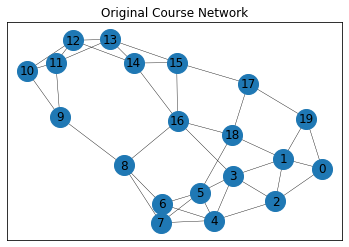

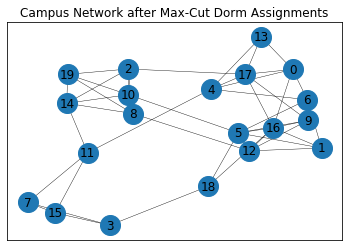

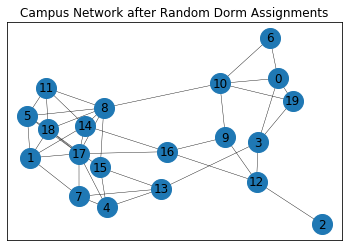

In [152]:
nx.draw_networkx(toyU, node_size=400, with_labels=True, width = .4)
plt.title('Original Course Network')
plt.show()
toyU_quantum_campus = construct_campus_graph(toyU, toyU_quantum_group_graphs, 2, .7, .1, .05)
nx.draw_networkx(toyU_quantum_campus, node_size=400, with_labels=True, width = .4)
plt.title('Campus Network after Max-Cut Dorm Assignments')
plt.show()
toyU_random_campus = construct_campus_graph(toyU, toyU_random_group_graphs, 2, .7, .1, .05)
nx.draw_networkx(toyU_random_campus, node_size=400, with_labels=True, width = .4)
plt.title('Campus Network after Random Dorm Assignments')
plt.show()

We note that in this small of a case, random groupings assigns a widely varying percentage of students to each dorm, and to a lesser extent, the quantum algorithm does as well. This assignment affects the density of the graph, and thus it would make for a rather poor simulation (along with the small population). We can see, however, that only 1 course edges remains in the quantum case (5-6), while many remain in the random case (0-19), (5-18), etc. This suggests that the quantum case has limited the vectors of transmission only to floors, dorms, and cross campus contact while the randomness has not. We must test, however, if this is actually empirically effective. NOTE: If re-run, you may find different results, we only describe the pre-run data

### Harvey-Mudd Campus Simulation

DISCLAIMER: THIS IS NOT ACUTALLY HARVEY-MUDD ENROLLMENT DATA, rather it is a network designed to match Cornell liberal arts college data, with around 800 students, and 8 2 floor dorms (roughly the Harvey Mudd statistics)

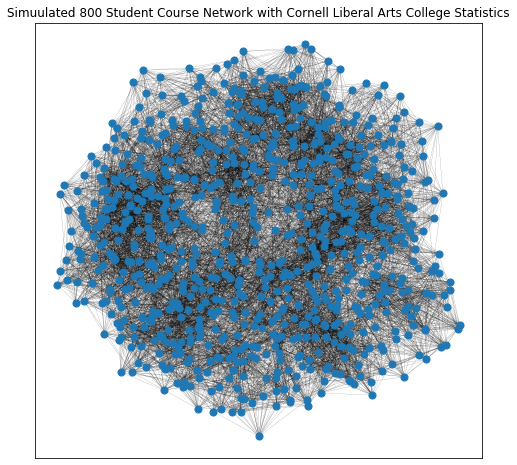

In [158]:
hm_n = 800
# Parameters fro a graph this size explained in "Testing D-Wave Hybrid Solver Capabilities on Small World Graphs.ipynb"
hm = small_world(hm_n, 32, .15) 
plt.figure(figsize = (8,8))
nx.draw_networkx(hm, node_size=50, with_labels=False, width = .1)
plt.title("Simuulated 800 Student Course Network with Cornell Liberal Arts College Statistics")
plt.show()

In [160]:
hm_10p_infected = np.random.choice(range(hm_n), int(hm_n * .1), replace=False)
hm_random_group_graphs = random_grouping(hm, 16)
# limit chosen to be above 800/16 = 50 so that we group into 16 groups
hm_quantum_group_graphs = binary_split(hm, limit = 70) 

In [176]:
def plot_random_quantum_campus_comparison(quantum_campus, random_campus, floors_per_dorm, num_dorms, infected, 
                                          r_infect=0.1, r_recover=0.1, iterations = 100):    
    """
    Plots side by side the disease spread on a quantum vs random dorm-assigned campus
    """
    quantum_model, quantum_trends, _ = sim_virus(quantum_campus, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    quantum_viz = DiffusionTrend(quantum_model, quantum_trends)
    
    random_model, random_trends, _ = sim_virus(random_campus, infected_nodes = infected, iteration = iterations, 
                                                   r_infect = r_infect, r_recover=r_recover)
    random_viz = DiffusionTrend(random_model, random_trends)
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    plot(random_viz, ax[0], "Assigned to {} Dorms With {} Floors Each Using Randomized Algorithm ".format(
        num_dorms, floors_per_dorm))
    plot(quantum_viz, ax[1], "Assigned to {} Dorms With {} Floors Each Using A Quantum Computer".format(
        num_dorms, floors_per_dorm))

In [257]:
hm_quantum_campus = construct_campus_graph(hm, hm_quantum_group_graphs, 2, .2, .005, .0001)
hm_random_campus = construct_campus_graph(hm, hm_random_group_graphs, 2, .2, .005, .0001)

10.47 12.1125


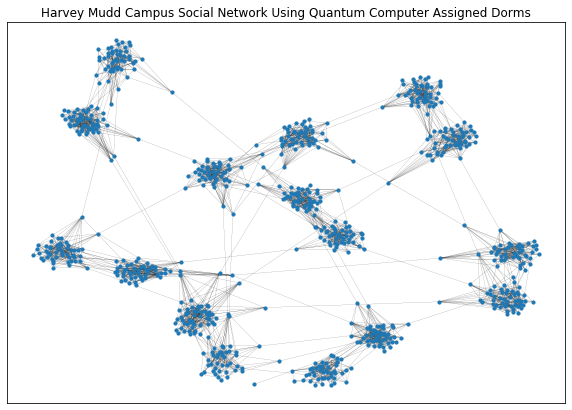

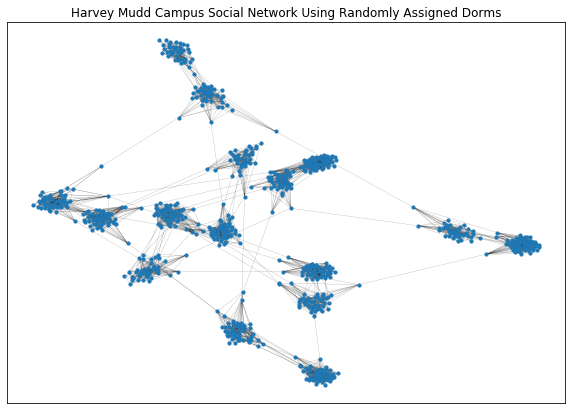

In [252]:
print(avg_degree(hm_quantum_campus), avg_degree(hm_random_campus))
plt.figure(figsize = (10,7))
nx.draw_networkx(hm_quantum_campus, node_size=10, with_labels=False, width = .1)
plt.title("Harvey Mudd Campus Social Network Using Quantum Computer Assigned Dorms")
plt.show()
plt.figure(figsize = (10,7))
nx.draw_networkx(hm_random_campus, node_size=10, with_labels=False, width = .1)
plt.title("Harvey Mudd Campus Social Network Using Randomly Assigned Dorms")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 286.48it/s]


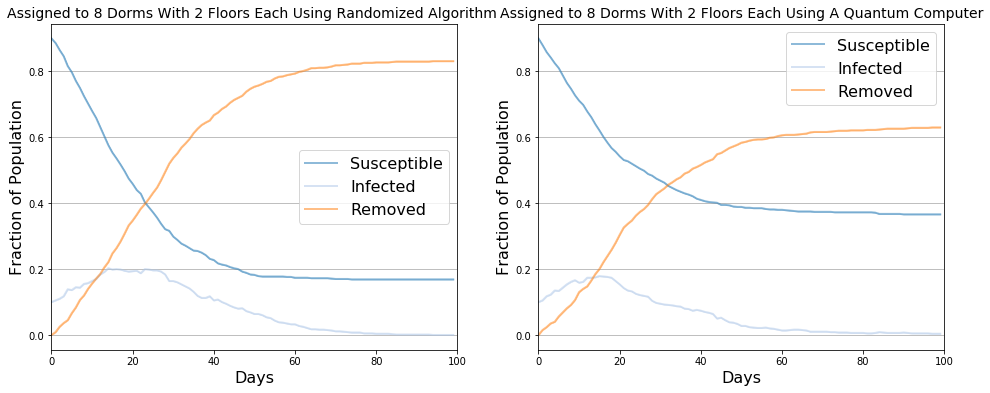

In [258]:
# It is very hard to figure out the R0 value once we implement all the dorm policy, we know it would be less than 6 
# since 6 is in the unregulated case. Note that an R value of r corresponds to r_infect of r/10*avg_degre, as explained above
plot_random_quantum_campus_comparison(hm_quantum_campus, hm_random_campus, 2, 8, hm_10p_infected, 
                                      r_infect=0.2/avg_degree(hm_quantum_campus), r_recover=0.1, iterations = 100)  

In [238]:
def virus_outcomes(G, infected, r_infect, r_recover):
    """
    Given a graph G, returns a tuple (total_infected, peak_infected), representing the total fraction of students infected
    through the course of the virus and the fraction of students infected at the peak
    """
    n = G.number_of_nodes()
    _, _, iteration_data = sim_virus(G, infected_nodes=infected, r_infect=r_infect, r_recover=r_recover, iteration=100)
    max_infected = np.max(np.array([iteration['node_count'][1] for iteration in iteration_data]))
    total_infected = iteration_data[-1]['node_count'][2]
    return max_infected/n, total_infected/n

In [246]:
def compare_outcomes_for_random_parameters(course_network, quantum_floors, random_floors, floors_per_dorm):
    """
    Takes in a quantum and random floor assignment and compares the disease spread on the two assignments with varying 
    values of r_infect, init_infect and varying inter-floor, dorm, and campus random edge probabilities.
    Compares the total infected and the max infected student outcomes for chosen disease statistics
    """
    n = course_network.number_of_nodes()
    init_infected_probabilities = np.linspace(.05, .5, 3)
    r_infect_values = np.linspace(.01, .1, 3)
    floor_edge_probabilities = np.linspace(.1, .6, 3)
    dorm_edge_probabilities = np.linspace(.001, .016, 3)
    campus_edge_probabilites = np.linspace(.00005, .0005, 3)
    
    max_infected_random, total_infected_random, max_infected_quantum, total_infected_quantum = [], [], [], []
    
    for init_infect_prob in init_infected_probabilities:
        for r_infect in r_infect_values:
            for floor_edge_prob in floor_edge_probabilities:
                for dorm_edge_prob in dorm_edge_probabilities:
                    for campus_edge_prob in campus_edge_probabilites:
                    
                        quantum_campus = construct_campus_graph(course_network, quantum_floors, 2, floor_edge_prob, 
                                                                dorm_edge_prob, campus_edge_prob)
                        random_campus = construct_campus_graph(course_network, random_floors, 2, floor_edge_prob, 
                                                                dorm_edge_prob, campus_edge_prob)
                    
                        init_infected_nodes = np.random.choice(range(n), int(n * init_infect_prob), replace=False)
                    
                        quantum_outcome = virus_outcomes(quantum_campus, init_infected_nodes, r_infect, .1)
                        max_infected_quantum.append(quantum_outcome[0])
                        total_infected_quantum.append(quantum_outcome[1])
                    
                        random_outcome = virus_outcomes(random_campus, init_infected_nodes, r_infect, .1)
                        max_infected_random.append(random_outcome[0])
                        total_infected_random.append(random_outcome[1])
    
    return max_infected_random, total_infected_random, max_infected_quantum, total_infected_quantum 

In [248]:
hm_various_stat_outcomes = compare_outcomes_for_random_parameters(hm, hm_quantum_group_graphs, hm_random_group_graphs, 2)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 346.85it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 336.47it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 368.62it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 401.45it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 373.01it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 482.06it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 474.63it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 409.09it/s]


In [250]:
max_infected_random, total_infected_random, max_infected_quantum, total_infected_quantum =  hm_various_stat_outcomes
print('reduced peak infections on average by:', (sum(max_infected_random)-sum(max_infected_quantum))/3**5)
print('reduced total infections on average by:', (sum(total_infected_random)-sum(total_infected_quantum))/3**5)
print('Quantum had lower peak in {} cases'.format(sum([q<r for q,r in zip(max_infected_quantum, max_infected_random)])/3**5))
print('Quantum had less total in {} cases'.format(sum([q<r for q,r in zip(total_infected_quantum, total_infected_random)])/3**5))

reduced peak infections on average by: 0.02300411522633746
reduced total infections on average by: 0.017175925925926094
Quantum had lower peak in 0.6872427983539094 cases
Quantum had less total in 0.5308641975308642 cases


Notes

1) By inspecting the results, we see that in most of the parameter combinations, both quantum and random dorm assignments lead to 100 percent of students getting virus. This does not allow us to compare the two very well.

2) We can notice, however, by choosing low values for all of these, that the quantum computer assignment seems to beat the random assignment. Thus our results are contingent upon keeping most of these 5 parameters low somehow. This then becomes an epidemiology/public health/privacy question: how much can we actually limit cross floor/dorm/campus contact, how likely will the disease spread in one instance of physical proximity, and how many students do we expect to initially be infected. These correspond to the 5 parameters in our code.

The last thing we will do then is assume we can keep all 5 of these parameters down, and compare quantum vs random assignments repeatedly to make sure we didn't get lucky in our 1 simulation. We will assume only 5% initial infection, .02 r_infect,  .2 probability of interaction within a dorm floor, .005 probability of interaction within a dorm, and .0001 probability of interaction within the campus. 

In [264]:
max_infected_random_low_p, total_infected_random_low_p, max_infected_quantum_low_p, total_infected_quantum_low_p = [],[],[],[]
for i in range(10):
    hm_5p_infected_temp = np.random.choice(range(hm_n), int(hm_n * .05), replace=False)
    hm_random_group_graphs_temp = random_grouping(hm, 16)
    # limit chosen to be above 800/16 = 50 so that we group into 16 groups
    hm_quantum_group_graphs_temp = binary_split(hm, limit = 70) 
    hm_quantum_campus_temp = construct_campus_graph(hm, hm_quantum_group_graphs_temp, 2, .2, .005, .0001)
    hm_random_campus_temp = construct_campus_graph(hm, hm_random_group_graphs_temp, 2, .2, .005, .0001)
    quantum_outcomes_temp = virus_outcomes(hm_quantum_campus_temp, hm_5p_infected_temp, .02, .1)
    random_outcomes_temp = virus_outcomes(hm_random_campus_temp, hm_5p_infected_temp, .02, .1)
    max_infected_random_low_p.append(random_outcomes_temp[0])
    total_infected_random_low_p.append(random_outcomes_temp[1])
    max_infected_quantum_low_p.append(quantum_outcomes_temp[0])
    total_infected_quantum_low_p.append(quantum_outcomes_temp[1])

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 397.89it/s]


In [267]:
print('reduced peak infections on average by:', (sum(max_infected_random_low_p)-sum(max_infected_quantum_low_p))/10)
print('reduced total infections on average by:', (sum(total_infected_random_low_p)-sum(total_infected_quantum_low_p))/10)
print('Quantum had lower peak in {} cases'.format(sum([q<r for q,r in zip(max_infected_quantum_low_p, max_infected_random_low_p)])/10))
print('Quantum had less total in {} cases'.format(sum([q<r for q,r in zip(total_infected_quantum_low_p, total_infected_random_low_p)])/10))
print('std dev for reduced max infections: ', np.std(np.array(max_infected_random_low_p)/10-np.array(max_infected_quantum_low_p)/10)) 
print('std dev for reduced total infections: ', np.std(np.array(total_infected_random_low_p)/10-np.array(total_infected_quantum_low_p)/10)) 

reduced peak infections on average by: 0.049249999999999974
reduced total infections on average by: 0.167375
Quantum had lower peak in 0.8 cases
Quantum had less total in 0.9 cases
std dev for reduced max infections:  0.004119769411022904
std dev for reduced total infections:  0.012423698372465423


#### Conclusion: 
If it is possible to reduce the 5 parameters to low enough values, quantum computer assigned dorms may be able to save on average around 17 +/- 1 percent of students and reduce the peak by around 5 +/- .1 percent

# Answering Q5: Weighting viral edges more:

Below we begin an exploration on to the advantages of weighting edges connecting an infected to a susceptible person higher than other edges. We have abandoned this as of now 5/1/2020 because we can simply quarantine these people a priori in the real world (provided we know they are sick)

In [126]:
# Convert an unweighted graph to a weighted graph where edges connecting a non-infected to infected node weighted more
def convert_to_weighted(G, infected):
    G_weighted = nx.Graph()
    G_edges = G.edges
    G_n = len(G_edges)
    for edge in G_edges:
        u, v = edge
        if (u in infected and v not in infected) or (v in infected and u not in infected):
            G_weighted.add_edge(u,v, weight = 5)
        else:
            G_weighted.add_edge(u,v, weight = 1)
    return G_weighted
            
# Create QUBO dict for D-Wave to optimize
def weighted_maxcut_qubo(G):
    # The Hamiltonian is H = sum(Pauli_Z(i) x Pauli_Z(j) - I)/2
    # The eigenvalue is the negation of the edges in cut solution
    # The QUBO should be -xi-xj+2xixj, we label it as Q
    Q = defaultdict(int)
    for u, v in G.edges:
        w = G.get_edge_data(u,v)['weight']
        Q[(u,u)]+= -w
        Q[(v,v)]+= -w
        Q[(u,v)]+= 2*w
    return Q

100%|██████████████████████████████████████████████| 100/100 [00:03<00:00, 32.73it/s]


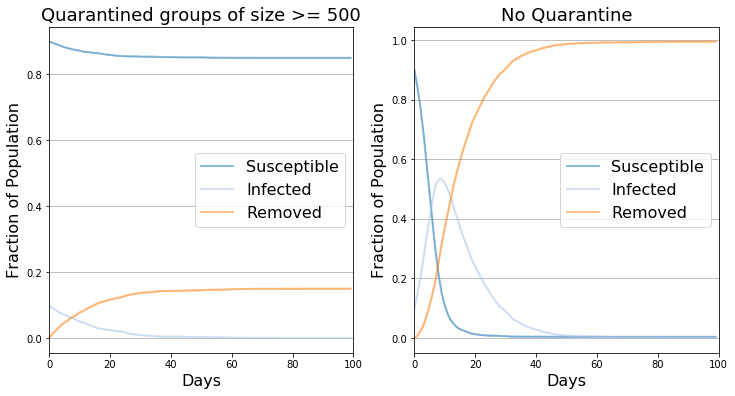

In [127]:
cornell_approx_weighted = convert_to_weighted(cornell_approx, cornell_approx_infected)
plot_comparison(cornell_approx_weighted, cornell_approx_infected, r_infect = .6/cornell_approx_avg_degree, 
                r_recover = .1, iterations = 100, group_sizes = [500])

#### Conclusion:
This does not look much different than the same test with unweighted edges, we also lost interest in this direction due to the reasons in the intro.

#### Add name here if contributed
Contributors: James Sud, Victor Li

Quantum Computing at Berkeley Club